# Import modules

In [1]:
import pyspark.sql.functions as F
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
# initialize the session
spark = SparkSession.builder.appName('Weather_AUS').getOrCreate()

# Load dataset

In [3]:
df = spark.read.csv('weatherAUS.csv', header=True, sep=',',inferSchema=True)
df.show(5)

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|          No|
|2008-12-02|

In [4]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [5]:
df.dtypes

[('Date', 'date'),
 ('Location', 'string'),
 ('MinTemp', 'string'),
 ('MaxTemp', 'string'),
 ('Rainfall', 'string'),
 ('Evaporation', 'string'),
 ('Sunshine', 'string'),
 ('WindGustDir', 'string'),
 ('WindGustSpeed', 'string'),
 ('WindDir9am', 'string'),
 ('WindDir3pm', 'string'),
 ('WindSpeed9am', 'string'),
 ('WindSpeed3pm', 'string'),
 ('Humidity9am', 'string'),
 ('Humidity3pm', 'string'),
 ('Pressure9am', 'string'),
 ('Pressure3pm', 'string'),
 ('Cloud9am', 'string'),
 ('Cloud3pm', 'string'),
 ('Temp9am', 'string'),
 ('Temp3pm', 'string'),
 ('RainToday', 'string'),
 ('RainTomorrow', 'string')]

In [6]:
# convert spark dataframe to pandas
# --> to use pandas specific operations and libraries for further analysis and processing
pandas_df = df.toPandas()
pandas_df.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NA,NA,W,44,W,...,71,22,1007.7,1007.1,8,NA,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0,NA,NA,WNW,44,NNW,...,44,25,1010.6,1007.8,NA,NA,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0,NA,NA,WSW,46,W,...,38,30,1007.6,1008.7,NA,2,21,23.2,No,No
3,2008-12-04,Albury,9.2,28,0,NA,NA,NE,24,SE,...,45,16,1017.6,1012.8,NA,NA,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1,NA,NA,W,41,ENE,...,82,33,1010.8,1006,7,8,17.8,29.7,No,No


# Data analysis 


In [7]:
print('Number of records: ', df.count())

Number of records:  145460


In [8]:
# Count unique values
unique_counts = df.select([F.col(c) for c in df.columns])
unique_counts_summary = unique_counts.agg(*[F.countDistinct(F.col(c)).alias(c) for c in df.columns])
unique_counts_summary.show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|3436|      49|    390|    506|     682|        359|     146|         17|           68|        17|        17|          44|          45|        102|        102|        547|        550|      11|      11|    442|    503|        3|           3|
+----+--------+-------+-------+-----

In [9]:
# Rainfall analysis
df.groupBy("Rainfall").count().orderBy("count", ascending=False).show()

+--------+-----+
|Rainfall|count|
+--------+-----+
|       0|91080|
|     0.2| 8761|
|     0.4| 3782|
|      NA| 3261|
|     0.6| 2592|
|     0.8| 2056|
|       1| 1759|
|     1.2| 1535|
|     1.4| 1377|
|     1.6| 1200|
|     1.8| 1104|
|       2| 1037|
|     2.2|  986|
|     2.4|  844|
|     2.6|  841|
|     2.8|  727|
|       3|  712|
|     3.2|  669|
|     3.4|  605|
|     3.8|  598|
+--------+-----+
only showing top 20 rows



In [10]:
# Evaporation analysis
df.groupBy("Evaporation").count().orderBy("count", ascending=False).show()

+-----------+-----+
|Evaporation|count|
+-----------+-----+
|         NA|62790|
|          4| 3339|
|          8| 2609|
|        2.2| 2095|
|          2| 2032|
|        2.6| 2003|
|        2.4| 2003|
|        1.8| 1979|
|          3| 1973|
|        3.4| 1967|
|        3.2| 1956|
|        2.8| 1921|
|        1.6| 1861|
|        3.6| 1844|
|        3.8| 1825|
|          5| 1784|
|        1.4| 1758|
|        5.4| 1688|
|        1.2| 1679|
|          6| 1673|
+-----------+-----+
only showing top 20 rows



In [11]:
# Sunshine analysis
df.groupBy("Sunshine").count().orderBy("count", ascending=False).show()

+--------+-----+
|Sunshine|count|
+--------+-----+
|      NA|69835|
|       0| 2359|
|    10.7| 1101|
|      11| 1094|
|    10.8| 1069|
|    10.5| 1027|
|    10.9| 1021|
|    10.3| 1010|
|    10.2|  993|
|      10|  984|
|    11.1|  978|
|    10.6|  971|
|    10.4|  969|
|     9.8|  967|
|    10.1|  949|
|     9.2|  925|
|    11.2|  909|
|     9.9|  897|
|     9.5|  866|
|     9.6|  859|
+--------+-----+
only showing top 20 rows



In [12]:
# RainToday analysis
df.groupBy("RainToday").count().orderBy("count", ascending=False).show()

+---------+------+
|RainToday| count|
+---------+------+
|       No|110319|
|      Yes| 31880|
|       NA|  3261|
+---------+------+



In [13]:
# RainTomorrow analysis
df.groupBy("RainTomorrow").count().orderBy("count", ascending=False).show()

+------------+------+
|RainTomorrow| count|
+------------+------+
|          No|110316|
|         Yes| 31877|
|          NA|  3267|
+------------+------+



In [14]:
# Display NA values
df.select([F.count(F.when(F.col(c) == 'NA', c)).alias(c) for c in df.columns]).show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|   1485|   1261|    3261|      62790|   69835|      10326|        10263|     10566|      4228|        1767|        3062|       2654|       4507|      15065|      15028|   55888|   59358|   1767|   3609|     3261|        3267|
+----+--------+-------+-------+-----

# Perform SQL Operations

In [15]:
df.createOrReplaceTempView('table')

In [16]:
spark.sql("select * from table limit 5").show()

+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|       No|          No|
|2008-12-02|

In [17]:
# Count unique values
unique_counts_query = ", ".join([f"COUNT(DISTINCT `{c}`) AS `{c}_unique_count`" for c in df.columns])
final_unique_query = f"SELECT {unique_counts_query} FROM table"
spark.sql(final_unique_query).show()

+-----------------+---------------------+--------------------+--------------------+---------------------+------------------------+---------------------+------------------------+--------------------------+-----------------------+-----------------------+-------------------------+-------------------------+------------------------+------------------------+------------------------+------------------------+---------------------+---------------------+--------------------+--------------------+----------------------+-------------------------+
|Date_unique_count|Location_unique_count|MinTemp_unique_count|MaxTemp_unique_count|Rainfall_unique_count|Evaporation_unique_count|Sunshine_unique_count|WindGustDir_unique_count|WindGustSpeed_unique_count|WindDir9am_unique_count|WindDir3pm_unique_count|WindSpeed9am_unique_count|WindSpeed3pm_unique_count|Humidity9am_unique_count|Humidity3pm_unique_count|Pressure9am_unique_count|Pressure3pm_unique_count|Cloud9am_unique_count|Cloud3pm_unique_count|Temp9am_uniq

In [18]:
# Rainfall analysis
spark.sql("SELECT Rainfall, COUNT(*) AS count FROM table GROUP BY Rainfall ORDER BY count DESC").show()

+--------+-----+
|Rainfall|count|
+--------+-----+
|       0|91080|
|     0.2| 8761|
|     0.4| 3782|
|      NA| 3261|
|     0.6| 2592|
|     0.8| 2056|
|       1| 1759|
|     1.2| 1535|
|     1.4| 1377|
|     1.6| 1200|
|     1.8| 1104|
|       2| 1037|
|     2.2|  986|
|     2.4|  844|
|     2.6|  841|
|     2.8|  727|
|       3|  712|
|     3.2|  669|
|     3.4|  605|
|     3.8|  598|
+--------+-----+
only showing top 20 rows



In [19]:
# Evaporation analysis
spark.sql("SELECT Evaporation, COUNT(*) AS count FROM table GROUP BY Evaporation ORDER BY count DESC").show()


+-----------+-----+
|Evaporation|count|
+-----------+-----+
|         NA|62790|
|          4| 3339|
|          8| 2609|
|        2.2| 2095|
|          2| 2032|
|        2.6| 2003|
|        2.4| 2003|
|        1.8| 1979|
|          3| 1973|
|        3.4| 1967|
|        3.2| 1956|
|        2.8| 1921|
|        1.6| 1861|
|        3.6| 1844|
|        3.8| 1825|
|          5| 1784|
|        1.4| 1758|
|        5.4| 1688|
|        1.2| 1679|
|          6| 1673|
+-----------+-----+
only showing top 20 rows



In [20]:
# Sunshine analysis
spark.sql("SELECT Sunshine, COUNT(*) AS count FROM table GROUP BY Sunshine ORDER BY count DESC").show()


+--------+-----+
|Sunshine|count|
+--------+-----+
|      NA|69835|
|       0| 2359|
|    10.7| 1101|
|      11| 1094|
|    10.8| 1069|
|    10.5| 1027|
|    10.9| 1021|
|    10.3| 1010|
|    10.2|  993|
|      10|  984|
|    11.1|  978|
|    10.6|  971|
|    10.4|  969|
|     9.8|  967|
|    10.1|  949|
|     9.2|  925|
|    11.2|  909|
|     9.9|  897|
|     9.5|  866|
|     9.6|  859|
+--------+-----+
only showing top 20 rows



In [21]:
# RainToday analysis
spark.sql("SELECT RainToday, COUNT(*) AS count FROM table GROUP BY RainToday ORDER BY count DESC").show()


+---------+------+
|RainToday| count|
+---------+------+
|       No|110319|
|      Yes| 31880|
|       NA|  3261|
+---------+------+



In [22]:
# RainTomorrow analysis
spark.sql("SELECT RainTomorrow, COUNT(*) AS count FROM table GROUP BY RainTomorrow ORDER BY count DESC").show()


+------------+------+
|RainTomorrow| count|
+------------+------+
|          No|110316|
|         Yes| 31877|
|          NA|  3267|
+------------+------+



In [23]:
# Count NA values
na_counts_query = ", ".join([f"SUM(CASE WHEN `{c}` = 'NA' THEN 1 ELSE 0 END) AS `{c}_na_count`" for c in df.columns])
final_query = f"SELECT {na_counts_query} FROM table"
spark.sql(final_query).show()

+-------------+-----------------+----------------+----------------+-----------------+--------------------+-----------------+--------------------+----------------------+-------------------+-------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+-----------------+-----------------+----------------+----------------+------------------+---------------------+
|Date_na_count|Location_na_count|MinTemp_na_count|MaxTemp_na_count|Rainfall_na_count|Evaporation_na_count|Sunshine_na_count|WindGustDir_na_count|WindGustSpeed_na_count|WindDir9am_na_count|WindDir3pm_na_count|WindSpeed9am_na_count|WindSpeed3pm_na_count|Humidity9am_na_count|Humidity3pm_na_count|Pressure9am_na_count|Pressure3pm_na_count|Cloud9am_na_count|Cloud3pm_na_count|Temp9am_na_count|Temp3pm_na_count|RainToday_na_count|RainTomorrow_na_count|
+-------------+-----------------+----------------+----------------+-----------------+-------------------

# Data Preprocessing

In [24]:
# Drop NA values in Rain Tomorrow 
print('Number of NA values in RainTomorrow before filtering:',df.filter(F.col("RainTomorrow") == 'NA').count())
print('Number of records before fitering:', df.count())
df = df.filter(F.col('RainTomorrow') != 'NA')
print('Number of NA values in RainTomorrow:',df.filter(F.col("RainTomorrow") == 'NA').count())
print('Number of records:', df.count())

Number of NA values in RainTomorrow before filtering: 3267
Number of records before fitering: 145460
Number of NA values in RainTomorrow: 0
Number of records: 142193


In [25]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [26]:
# Convert string to double for some features
numerical_columns = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
    'Cloud3pm', 'Temp9am', 'Temp3pm'
]

categorical_columns = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

# Convert 'NA' to null and to double type
for col_name in numerical_columns:
    df = df.withColumn(col_name, F.when(F.col(col_name) == 'NA', None).otherwise(F.col(col_name).cast(DoubleType())))

for col_name in categorical_columns:
    df = df.withColumn(col_name, F.when(F.col(col_name) == 'NA', None).otherwise(F.col(col_name)))


In [27]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- Evaporation: double (nullable = true)
 |-- Sunshine: double (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- Cloud9am: double (nullable = true)
 |-- Cloud3pm: double (nullable = true)
 |-- Temp9am: double (nullable = true)
 |-- Temp3pm: double (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [28]:
df.describe().show()

+-------+--------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+----------+----------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------+------------+
|summary|Location|          MinTemp|          MaxTemp|          Rainfall|      Evaporation|         Sunshine|WindGustDir|    WindGustSpeed|WindDir9am|WindDir3pm|     WindSpeed9am|     WindSpeed3pm|       Humidity9am|       Humidity3pm|       Pressure9am|       Pressure3pm|          Cloud9am|         Cloud3pm|           Temp9am|           Temp3pm|RainToday|RainTomorrow|
+-------+--------+-----------------+-----------------+------------------+-----------------+-----------------+-----------+-----------------+----------+----------+-----------------+-----------------+------------------+------------------+------------------+--

In [56]:
# Correlation matrix
columns = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
    'Cloud3pm', 'Temp9am', 'Temp3pm'
]
corr_df = pd.DataFrame()
for i in columns:
    corr = []
    for j in columns:
        corr.append(round(df.stat.corr(i, j), 2))
    corr_df = pd.concat([corr_df, pd.Series(corr)], axis=1)
corr_df.columns = columns
corr_df.insert(0, '', columns)
corr_df.set_index('')

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
,,,,,,,,,,,,,,,,
MinTemp,1.00,0.72,0.10,0.37,0.14,0.13,0.18,0.17,-0.18,-0.00,0.13,0.13,0.16,0.12,0.89,0.63
MaxTemp,0.72,1.00,-0.07,0.40,0.25,0.09,0.02,0.06,-0.43,-0.46,0.10,0.10,-0.11,-0.10,0.87,0.88
Rainfall,0.10,-0.07,1.00,-0.05,-0.10,0.09,0.08,0.05,0.20,0.23,-0.00,-0.00,0.15,0.13,0.01,-0.08
Evaporation,0.37,0.40,-0.05,1.00,0.51,0.13,0.17,0.13,-0.32,-0.25,0.23,0.23,0.16,0.17,0.40,0.37
Sunshine,0.14,0.25,-0.10,0.51,1.00,0.05,0.10,0.12,-0.25,-0.25,0.28,0.28,0.06,0.08,0.22,0.29
WindGustSpeed,0.13,0.09,0.09,0.13,0.05,1.00,0.53,0.61,-0.17,-0.00,0.18,0.18,0.01,0.06,0.12,0.11
WindSpeed9am,0.18,0.02,0.08,0.17,0.10,0.53,1.00,0.51,-0.22,-0.01,0.13,0.13,0.10,0.12,0.14,0.02
WindSpeed3pm,0.17,0.06,0.05,0.13,0.12,0.61,0.51,1.00,-0.12,0.08,0.20,0.21,0.09,0.10,0.16,0.11
Humidity9am,-0.18,-0.43,0.20,-0.32,-0.25,-0.17,-0.22,-0.12,1.00,0.61,-0.01,-0.01,0.24,0.16,-0.37,-0.39


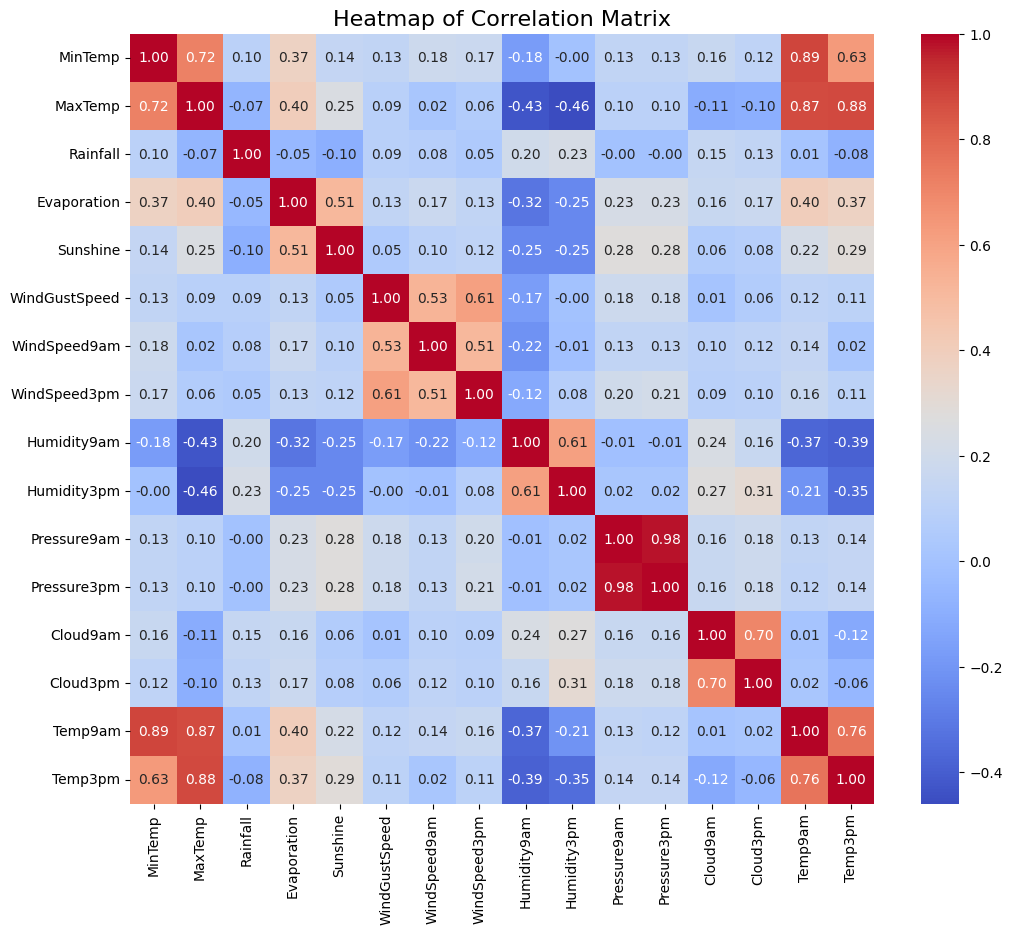

In [57]:
# Loại bỏ cột index phụ để đảm bảo dữ liệu tương thích với heatmap
corr_df_numeric = corr_df.set_index('').astype(float)

# Vẽ heatmap từ corr_df
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df_numeric, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)

# Thiết lập tiêu đề
plt.title("Heatmap of Correlation Matrix", fontsize=16)
plt.show()


In [30]:
# Display NA values
df.select([F.count(F.when(F.col(c) == 'NA', c)).alias(c) for c in df.columns]).show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|      0|      0|       0|          0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|        0|           0|
+----+--------+-------+-------+-----

In [31]:
# Dispaly null values
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|    637|    322|    1406|      60843|   67816|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|   53657|   57094|    904|   2726|     1406|           0|
+----+--------+-------+-------+-----

In [32]:
# get mean value of column
mean = df.select([F.mean(df['MinTemp'])]).collect()[0][0]
mean

12.18639972872931

In [33]:
# fill null values for LoanAmount
df = df.na.fill(mean, ['MinTemp'])

In [34]:
# get mode value of column
# return the gender with the highest count
df.groupBy('WindGustDir').count().orderBy('count', ascending=False).first()[0]

'W'

--> That is how we fill the value for numerical values and categorial values. Now we do the same thing with other features.

In [29]:
numerical_cols = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
    'Cloud3pm', 'Temp9am', 'Temp3pm'
]

categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [30]:
# fill null values for numerical columns
for col in numerical_cols:
    mean = df.select(F.mean(df[col])).collect()[0][0]
    df = df.na.fill(mean, [col])

In [31]:
# fill null values for categorial columns
for col in categorical_cols:
    mode = df.groupBy(col).count().orderBy('count', ascending=False).first()[0]
    df = df.na.fill(mode, [col])

In [32]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|   0|       0|      0|      0|       0|          0|       0|          0|            0|         0|         0|           0|           0|          0|          0|          0|          0|       0|       0|      0|      0|        0|           0|
+----+--------+-------+-------+-----

In [33]:
# Replacing Y -> 1, N -> 0 in Loan_Status
df = df.withColumn('RainTomorrow', F.when(df['RainTomorrow'] == 'Yes', 1).otherwise(0))
df.show(2)

+----------+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+-----------------+-----------------+-------+-------+---------+------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|         Cloud9am|         Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+----------+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+-----------------+-----------------+-------+-------+---------+------------+
|2008-12-01|  Albury|   13.4|   22.9|     0.6|5.469824216349106|7.624853113193661|          W|         44.0|         W|       WNW|        20.0|        24.0|    

# Feature engineering

-> transforming raw data into meaningful features that can improve the performance of a machine learning model

In [40]:
df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- Evaporation: double (nullable = false)
 |-- Sunshine: double (nullable = false)
 |-- WindGustDir: string (nullable = false)
 |-- WindGustSpeed: double (nullable = false)
 |-- WindDir9am: string (nullable = false)
 |-- WindDir3pm: string (nullable = false)
 |-- WindSpeed9am: double (nullable = false)
 |-- WindSpeed3pm: double (nullable = false)
 |-- Humidity9am: double (nullable = false)
 |-- Humidity3pm: double (nullable = false)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- Cloud9am: double (nullable = false)
 |-- Cloud3pm: double (nullable = false)
 |-- Temp9am: double (nullable = false)
 |-- Temp3pm: double (nullable = false)
 |-- RainToday: string (nullable = false)
 |-- RainTomorrow: integer (nullable = false)



##### Performing feature engineering workflow using pyspark.ml to handle categorical and numerical columns

In [41]:
numerical_cols = [
    'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 
    'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
    'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 
    'Cloud3pm', 'Temp9am', 'Temp3pm'
]

categorical_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'Location']

# Index the string columns
# --> Creating transformers to transfer categorical value to numerical values
indexers = [StringIndexer(inputCol=col, outputCol="{0}_index".format(col)) for col in categorical_columns]

# encode the indexed values
# --> Creating transformers to transfer indexed values to one hot encoder
encoders = [OneHotEncoder(dropLast=False, inputCol=indexer.getOutputCol(), outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

input_columns = [encoder.getOutputCol() for encoder in encoders] + numerical_columns

# vetorize the encoded values
# To combine columns into one columns (vetor form)
assembler = VectorAssembler(inputCols=input_columns, outputCol="feature")


In [42]:
# Create the pipeline to transform the data
pipeline = Pipeline(stages=indexers+encoders+[assembler])

In [43]:
data_model = pipeline.fit(df)

In [44]:
# -> creating preprocessed df (indexer + encoder + [assembler])
transformed_df = data_model.transform(df)

In [45]:
transformed_df.show(1)

+----------+--------+-------+-------+--------+-----------------+-----------------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+-----------------+-------+-------+---------+------------+-----------------+----------------+----------------+---------------+-------------------------+------------------------+------------------------+-----------------------+--------------------+
|      Date|Location|MinTemp|MaxTemp|Rainfall|      Evaporation|         Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|         Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|WindGustDir_index|WindDir9am_index|WindDir3pm_index|RainToday_index|WindGustDir_index_encoded|WindDir9am_index_encoded|WindDir3pm_index_encoded|RainToday_index_encoded|             feature|
+----------+--------+-------+-------+--------+-----------------+----------------

In [46]:
# get input features and output columns
transformed_df = transformed_df.select(['feature', 'RainTomorrow'])

In [47]:
# split the data for train and test
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)

In [48]:
print(train_data.count())
print(test_data.count())

113916
28277


# Classifier model

## Logistic Regression

In [49]:
lr = LogisticRegression(featuresCol='feature', labelCol='RainTomorrow')
lr_model = lr.fit(train_data)

In [50]:
# predict on test data
predictions = lr_model.transform(test_data)
predictions.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|             feature|RainTomorrow|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(66,[0,16,32,48,5...|           0|[2.15883035378983...|[0.89649106173479...|       0.0|
|(66,[0,16,32,48,5...|           0|[2.12743987450340...|[0.89354172185722...|       0.0|
|(66,[0,16,32,48,5...|           0|[2.82998172444348...|[0.94427464041855...|       0.0|
|(66,[0,16,32,48,5...|           0|[3.22206369574399...|[0.96165618286541...|       0.0|
|(66,[0,16,32,48,5...|           1|[1.10866593682980...|[0.75188031718061...|       0.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [51]:
predictions = lr_model.transform(test_data)
auc_lr = BinaryClassificationEvaluator().setLabelCol('RainTomorrow')
print('AUC:', str(auc_lr.evaluate(predictions)))

AUC: 0.8658362902441736


## Random Forest 

In [52]:
rf = RandomForestClassifier(featuresCol='feature', labelCol='RainTomorrow')
rf_model = rf.fit(train_data)

In [53]:
# predict on test data
rf_predictions = rf_model.transform(test_data)
rf_predictions.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|             feature|RainTomorrow|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(66,[0,16,32,48,5...|           0|[17.4248624114906...|[0.87124312057453...|       0.0|
|(66,[0,16,32,48,5...|           0|[17.5287071156412...|[0.87643535578206...|       0.0|
|(66,[0,16,32,48,5...|           0|[16.7817576388486...|[0.83908788194243...|       0.0|
|(66,[0,16,32,48,5...|           0|[17.2385780431057...|[0.86192890215528...|       0.0|
|(66,[0,16,32,48,5...|           1|[17.3029908651041...|[0.86514954325520...|       0.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [54]:
auc_rf = BinaryClassificationEvaluator().setLabelCol('RainTomorrow')
print('AUC:', str(auc_rf.evaluate(rf_predictions)))

AUC: 0.8343492874590556


## Decision Tree

In [55]:
dct = DecisionTreeClassifier(featuresCol='feature', labelCol='RainTomorrow')
dct_model = dct.fit(train_data)

In [56]:
# predict on test data
dct_predictions = dct_model.transform(test_data)
dct_predictions.show(5)

+--------------------+------------+----------------+--------------------+----------+
|             feature|RainTomorrow|   rawPrediction|         probability|prediction|
+--------------------+------------+----------------+--------------------+----------+
|(66,[0,16,32,48,5...|           0|[68452.0,8390.0]|[0.89081491892454...|       0.0|
|(66,[0,16,32,48,5...|           0|[68452.0,8390.0]|[0.89081491892454...|       0.0|
|(66,[0,16,32,48,5...|           0|  [3510.0,417.0]|[0.89381207028265...|       0.0|
|(66,[0,16,32,48,5...|           0|[68452.0,8390.0]|[0.89081491892454...|       0.0|
|(66,[0,16,32,48,5...|           1|[68452.0,8390.0]|[0.89081491892454...|       0.0|
+--------------------+------------+----------------+--------------------+----------+
only showing top 5 rows



In [57]:
auc_dct = BinaryClassificationEvaluator().setLabelCol('RainTomorrow')
print('AUC:', str(auc_dct.evaluate(dct_predictions)))

AUC: 0.2962401380140286


## Gradient-Boosted Trees

In [58]:
gbt = GBTClassifier(featuresCol='feature', labelCol='RainTomorrow')
gbt_model = gbt.fit(train_data)

In [59]:
# predict on test data
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|             feature|RainTomorrow|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(66,[0,16,32,48,5...|           0|[0.88091328803768...|[0.85343827838915...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.01544432149580...|[0.88400223251396...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.12998708255215...|[0.90550742054291...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.18989642696595...|[0.91527337188224...|       0.0|
|(66,[0,16,32,48,5...|           1|[0.67588530068588...|[0.79441894910443...|       0.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [60]:
auc_gbt = BinaryClassificationEvaluator().setLabelCol('RainTomorrow')
print('AUC:', str(auc_gbt.evaluate(gbt_predictions)))

AUC: 0.8668494301421926


## Multilayer perceptron 


In [79]:
mlp = MultilayerPerceptronClassifier(layers=[66, 5, 4, 2], labelCol="RainTomorrow", featuresCol="feature", maxIter=100)
mlp_model = mlp.fit(train_data)

In [80]:
# predict on test data
mlp_predictions = mlp_model.transform(test_data)
mlp_predictions.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|             feature|RainTomorrow|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|(66,[0,16,32,48,5...|           0|[1.77762587744446...|[0.90688254569604...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.77762525106920...|[0.90688246230023...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.77762715808599...|[0.90688271620085...|       0.0|
|(66,[0,16,32,48,5...|           0|[1.77762708351055...|[0.90688270627188...|       0.0|
|(66,[0,16,32,48,5...|           1|[1.74216867640650...|[0.90205067156600...|       0.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [81]:
auc_mlp = BinaryClassificationEvaluator().setLabelCol('RainTomorrow')
print('AUC:', str(auc_mlp.evaluate(mlp_predictions)))

AUC: 0.8517281365697023
